* Today, we are going to understand `activations` and `how gradient descent go backward` in `neural networks` in more depth.

* `RNN` models are not optimizable easily, we will understand this today.

In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [52]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-01 15:18:42--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-04-01 15:18:42 (8.26 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [53]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [54]:
len(words)

32033

In [55]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [56]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


* By randomly selecting W1, b1, W2, b2... the `logits` we get at the end is not normalized due to which initial loss is too high, that is, to make loss low to start, initially we don't know out of 27 characters which will come next so,
all the `logits` should either be `zero` or `equal` `to give equally likely probability` for all 27 characters `(1/27)`,  

* we don't initially need bias b2, so make it zero by multiplying it by `0`. i.e we are `not biased with any character`.
* Multiply W2 by `0.01 to make all values decrease by factor of 100`.

#### Normalizing our logits by editing W2, b2 and issues with it:

In [25]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [26]:
 # same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): # no. of epochs
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


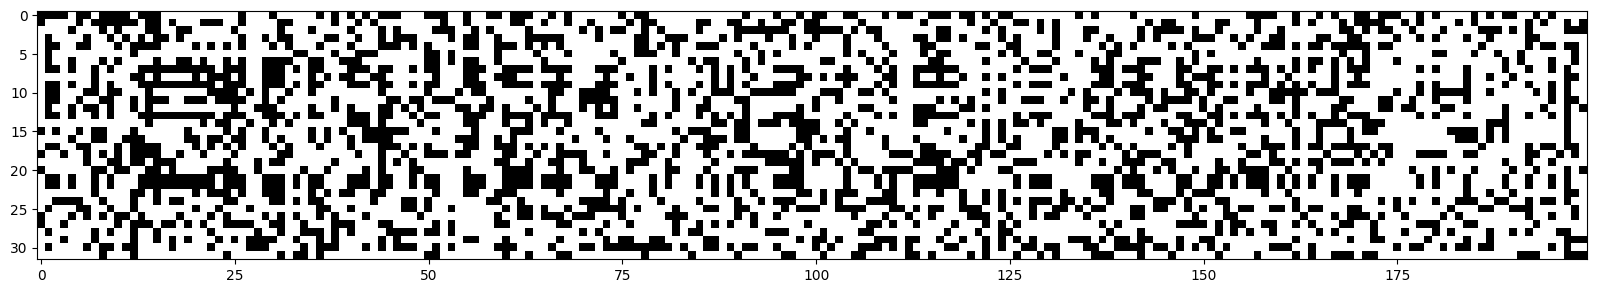

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # asking how many values of h are above 0.99 and it shows a boolean figure,

* Here, white spots means `True` and black spots means `False`, hence, there are lot of values `greater than 0.99`.

* If any of the column above, becomes purely white, then it is becomes, what we call a `dead neuron`, which basically does nothing in our neural net, just a trash.

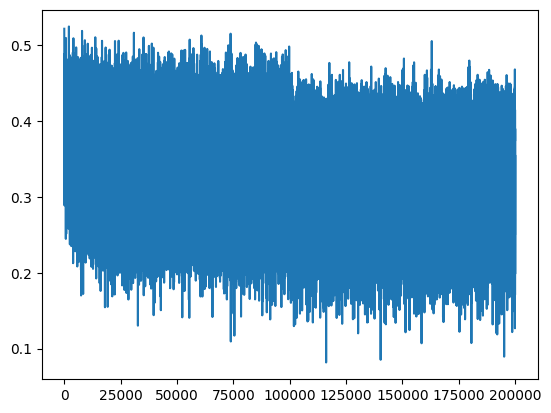

In [28]:
plt.plot(lossi)

(array([2165.,  152.,   94.,   59.,   51.,   49.,   48.,   36.,   35.,
          33.,   42.,   31.,   45.,   30.,   37.,   24.,   17.,   20.,
          20.,   14.,   28.,   17.,   12.,   22.,   34.,   20.,   22.,
          15.,    8.,   26.,   23.,   22.,   24.,   28.,   40.,   15.,
          23.,   36.,   20.,   27.,   21.,   25.,   30.,   53.,   45.,
          64.,   64.,   88.,  115., 2431.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

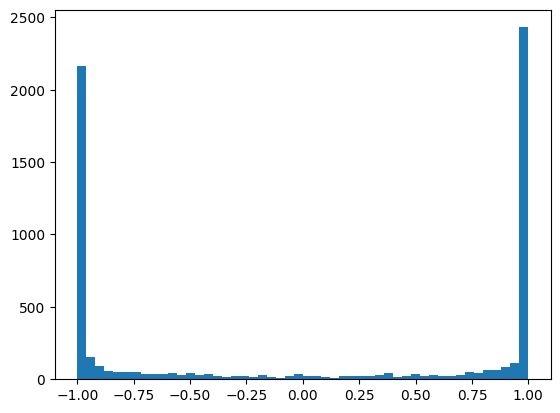

In [29]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   1.,   3.,   0.,   4.,   6.,   8.,  10.,  11.,
         20.,  26.,  51.,  67.,  76., 120., 156., 178., 223., 255., 301.,
        333., 348., 449., 557., 501., 375., 362., 311., 300., 278., 225.,
        215., 166., 106., 111.,  89.,  48.,  35.,  24.,  19.,  17.,   7.,
          3.,   3.,   0.,   0.,   0.,   1.]),
 array([-26.79987907, -25.76185238, -24.72382568, -23.68579899,
        -22.64777229, -21.6097456 , -20.5717189 , -19.53369221,
        -18.49566551, -17.45763882, -16.41961212, -15.38158543,
        -14.34355873, -13.30553204, -12.26750534, -11.22947865,
        -10.19145195,  -9.15342525,  -8.11539856,  -7.07737186,
         -6.03934517,  -5.00131847,  -3.96329178,  -2.92526508,
         -1.88723839,  -0.84921169,   0.188815  ,   1.2268417 ,
          2.26486839,   3.30289509,   4.34092178,   5.37894848,
          6.41697517,   7.45500187,   8.49302856,   9.53105526,
         10.56908195,  11.60710865,  12.64513535,  13.68316204,
         14.721188

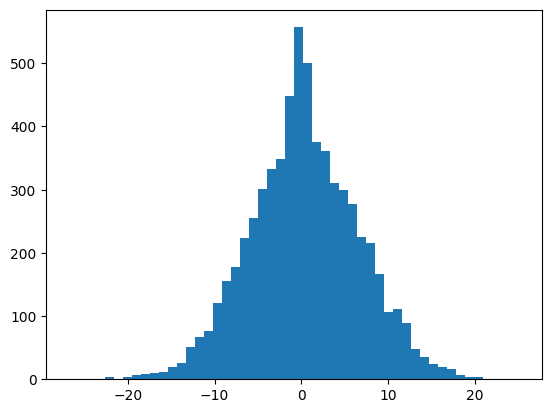

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50) # 50 here is, 50 pins.

* Now here are the two problems you will see by editing W2 :-
  * Firstly, we are not getting the `hockey stick curve as we expect` in `neural networks`, this is because during initialization, before editing our `neural net` was starting loss from around `27` and now it is only around `3`.
  * Secondly, you will see that, `hpreact` is taking lot's of values between `-15 and 15` ,and so `h` is taking lots of values as `1 or -1`, due to which during `back propagation`, `gradient of tanh` becomes `0`, and hence our `back prop algo` becomes useless on those neurons. It increases chance of `Dead Neurons`, which do nothing in the `neural net` for any of the examples.
  * Second point is also true for other `non-linearity activation functions` such as:
    * Sigmoid
    * tanh
    * Relu
    * Leaky Relu
    * Maxout
    * ELU


In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.1310746669769287


* `@torch.no_grad()` - This is a decorator. what this decorator does on top of this function is that whatever happens in this function is assumed by torch to never require any gradients so it will not do any of the `bookkeeping`, that it does, to keep `track of all the gradients` in anticipation of an eventual `backward pass`.

* It's almost as if all the `tensors` that get created here have a `requires_grad = False`. So this `decorator` makes everything much more efficient.

#### Let's change all the weights and bias this time

In [32]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)   #* 0.2 # 5/3 is for tanh
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


* `Real question` is how we set these numbers, that we multiplied to W1, b1, W2, b2.

tensor(0.0029) tensor(0.9918)
tensor(0.0010) tensor(0.9874)


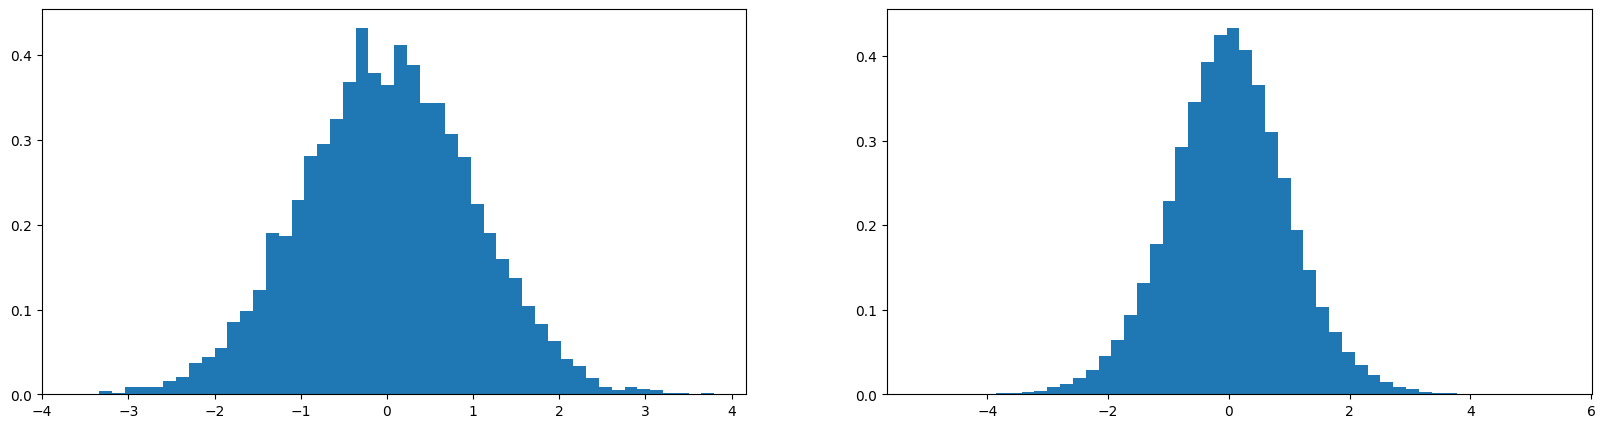

In [33]:
# JUST A EXAMPLE BELOW

x = torch.randn(1000, 10)
n = 1 / 10**0.5
w = torch.randn(10, 200) * n
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# EXAMPLE ENDED

* In a `neural net`, what we want is, that the values of w are such that the `standard deviation of x any y remains approximately equal`.
* So, to get values of `w`, we have to multiply by a number `n` to get the best close standard deviation for both x and y.
* It is found that the best value of `n` is `1/(square root of fanin)` , like here fanin is (number of input elements) `10`.

* `Many papers has been published on how to initialize neural nets, to get best results`.

* One such <a href="https://arxiv.org/abs/1502.01852">paper</a> was given by, Kaiming He (One of the researchers), `Delving Deep into Rectifiers: Surpassing Human-level Performance on ImageNet Classification`:
  * They studied , `CNN and ReLU and PReLU non-linearities.` Due to using ReLU, They are throwing almost half of the distribution, that's where they have to compensate by (called as) `Gain.` They initialize there weights with zero mean Gaussian distribution whose `std` is `sq.root of (2/fanin)`, fanin denoted as `nl`. They added this factor of `2` because of `Relu` which basically discards half of distribution and clamps it as zero.
  * Also in `Back Propagation`; what they find is basically if you properly initialize the forward pass, the backward pass is also approximately initialized up to a constant factor, that has to do with size of the number of hidden neurons in an early and late layer. but this choice not matters too much. 
  * this timing initialization is also implemented in `pytorch`.

* In `pytorch` for initialization,
  * `torch.nn.init.kaiming_normal_()` : Most common way of initializing our neural network.
    * keyword argument: `mode=` whether you want to normalize `activations` or like to `normalize the gradients` to always have gaussian with zero mean and a unit or `a standard deviation`. but we set it to default - `fan_in`
    * keyword argument: `nonlinearity=` you have to provide which activation you are using.

        `std = gain/sqroot(fan_mode)` for different activations has different gain.

* `NOTE`: This is section is now not that important in the modern neural networks, because now there are number of modern innovations that have made everything significantly more stable and more well-behaved and has become 
`less important to initialize these networks exactly right`.
* Some of modern innovations are : `residual connections`, `use of no. of normalization layers like **batch normalization**, **layer normalization**, **group normalization**`, now much better optimizers like `RMSprop`, `Adam`

* So without giving so much maths in it, simply normalize `weights` by dividing them by the `square root of fan-in`.

In [34]:
 # same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): # no. of epochs
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


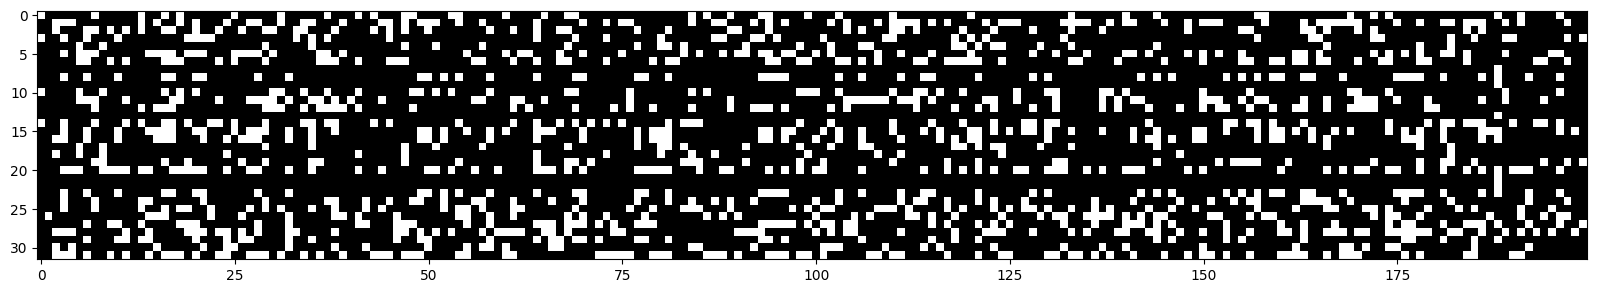

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # asking how many values of h are above 0.99 and it shows a boolean figure,

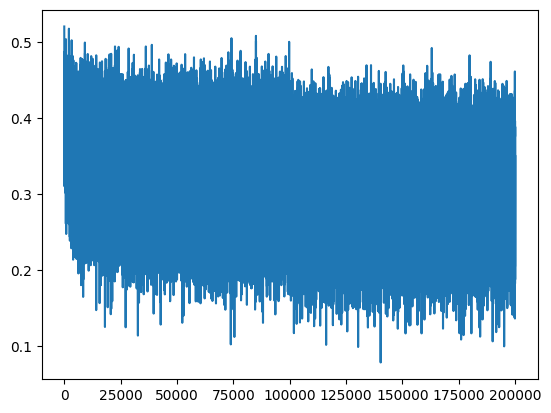

In [36]:
plt.plot(lossi)

(array([1059.,  229.,  163.,  142.,   95.,   83.,   67.,   63.,   57.,
          65.,   76.,   51.,   69.,   65.,   85.,   91.,   75.,   53.,
          62.,   76.,   70.,  100.,  117.,   91.,  110.,  125.,  104.,
          72.,  108.,   70.,   62.,   62.,   65.,   64.,   54.,   58.,
          65.,   62.,   53.,   53.,   53.,   66.,   67.,   81.,   93.,
         101.,  116.,  179.,  231., 1122.]),
 array([-9.99999940e-01, -9.59999942e-01, -9.19999943e-01, -8.79999944e-01,
        -8.39999945e-01, -7.99999946e-01, -7.59999948e-01, -7.19999949e-01,
        -6.79999950e-01, -6.39999951e-01, -5.99999952e-01, -5.59999954e-01,
        -5.19999955e-01, -4.79999956e-01, -4.39999957e-01, -3.99999958e-01,
        -3.59999959e-01, -3.19999961e-01, -2.79999962e-01, -2.39999963e-01,
        -1.99999964e-01, -1.59999965e-01, -1.19999967e-01, -7.99999678e-02,
        -3.99999690e-02,  2.98023224e-08,  4.00000286e-02,  8.00000274e-02,
         1.20000026e-01,  1.60000025e-01,  2.00000024e-01,  2.400000

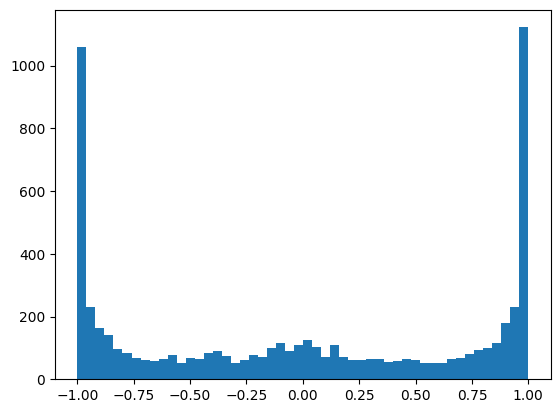

In [37]:
plt.hist(h.view(-1).tolist(), 50)

(array([  4.,   3.,   0.,   6.,   4.,   8.,   9.,  14.,  32.,  30.,  39.,
         69.,  68.,  73., 124., 156., 164., 192., 232., 291., 318., 369.,
        630., 891., 491., 340., 310., 299., 224., 221., 173., 124., 112.,
         92.,  67.,  43.,  49.,  31.,  34.,  21.,  17.,   8.,   3.,   4.,
          5.,   1.,   1.,   1.,   2.,   1.]),
 array([-8.91671085, -8.53556993, -8.15442902, -7.7732881 , -7.39214718,
        -7.01100626, -6.62986534, -6.24872442, -5.8675835 , -5.48644258,
        -5.10530167, -4.72416075, -4.34301983, -3.96187891, -3.58073799,
        -3.19959707, -2.81845615, -2.43731524, -2.05617432, -1.6750334 ,
        -1.29389248, -0.91275156, -0.53161064, -0.15046972,  0.2306712 ,
         0.61181211,  0.99295303,  1.37409395,  1.75523487,  2.13637579,
         2.51751671,  2.89865763,  3.27979855,  3.66093946,  4.04208038,
         4.4232213 ,  4.80436222,  5.18550314,  5.56664406,  5.94778498,
         6.3289259 ,  6.71006681,  7.09120773,  7.47234865,  7.85348957,
 

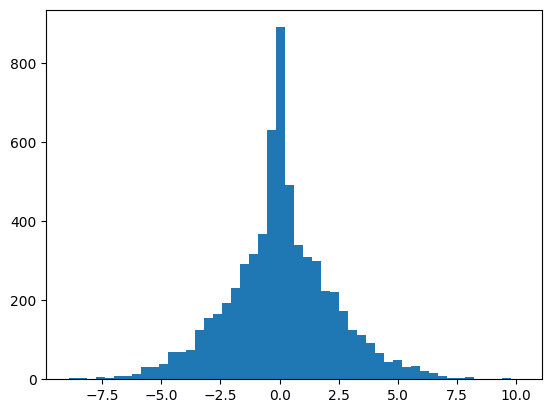

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50) # 50 here is, 50 pins.

In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


* `SO OUR MODEL TRAINED LIKE THIS`:

* loss log

* `original`:
  * train 2.1245384216308594
  * val   2.168196439743042

* `fix softmax confidently wrong`:
  * train 2.07
  * val   2.13

* `fix tanh layer too saturated at init`:
  * train 2.0355966091156006
  * val   2.1026785373687744

* `use semi-principled "kaiming init" instead of hacky init`:
  * train 2.0376641750335693
  * val   2.106989622116089

* `add batch norm layer`
  * train 2.0668270587921143
  * val 2.104844808578491

In [40]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.


In [41]:
# 4-dimensional example
logits = torch.tensor([0.0, 0.0, 0.0 ,0.0])
probs1 = torch.softmax(logits, dim=0)
probs1

tensor([0.2500, 0.2500, 0.2500, 0.2500])

## BATCH NORMALIZATION

* Given by the team at google in 2015 and it was an extremely impactful paper. It made it possible to train deep neural nets quite reliably.

* Paper says that, you have these `hidden layers before giving non-linearity`,  you'd like them to be roughly `gaussian` then why not `take the hidden states and just normalize them to be gaussian`.

* `REASON OF DOING BATCH NORMALIZATION:`
  * Idea here is we're trying to make `hpreact` roughly gaussian and that's because during `initialization` if these are way too small numbers then the `tanh` is kind of connective.
  * But during `initialization` if these are very large numbers then the `tanh` is way too `saturated` and gradient is in the `flow`.

In [42]:
hpreact.shape

torch.Size([32, 200])

In [43]:
hpreact.mean(0, keepdim=True).shape # 0 means along 0 dimension, mean is calculated

torch.Size([1, 200])

In [44]:
hpreact.std(0, keepdim=True).shape # 0 means along 0 dimension, standard deviation is calculated
# keepdim = False will remove that particular dimension

torch.Size([1, 200])

Now according to Batch Normalization, we can change `hpreact` as:

  * `hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)`.
  * But we won't achieve a very good result from this, we want these `roughly to be gaussian but only at initialization` but we don't want these to be forced to be gaussian always.

  * So we will also introduce `scale and shift` to fix this issue:
    * we're taking these normalized inputs and we are additionally scaling them by some `gain` and offsetting them by some bias to get our final output from this layer.

In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)   #* 0.2 # 5/3 is for tanh
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# allowing batch normalization gain to be initialized at just ones, ones will be in the shape of 1 by n hidden.
# we will also have bias which will be torched at zeros, it will also be of shape n by 1

bnmean_running = torch.zeros((1, n_hidden)) # not part of gradient based optimization.
bnstd_running = torch.ones((1, n_hidden)) # not part of gradient based optimization.

parameters = [C, W1, W2, b2, bngain, bnbias] # adding new parameters - bngain and bnbias.
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


* after `hpreact` is normalized, also multiply and add, `bngain` and `bnbias` to it.

Now, at initialization each neuron's firing values in this batch will be exactly `unit gaussian` and we'll have nice numbers, no matter what the distribution of the `hpreact` is `coming in`/ `coming out`, it will be in `gaussian` for each neuron and that's what we roughly want at least at initialization.

During optimization, we will be able to back propagate to be in game and being biased and change them so the network is given the full ability to do with this whatever it wants, internally.

In [62]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): # no. of epochs
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation # no use of bias b1 due to modified hpreact.
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch Normalization

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


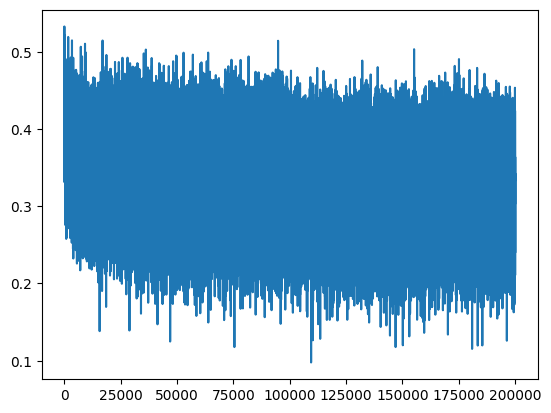

In [63]:
plt.plot(lossi)

* To calculate a single input example from the model, we perform a one more step after training,

In [64]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr] # we take the training set
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1 # get the pre-activations for every single training example.
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  # and now these are fixed numbers as the meaning of the entire training set.

`NOTE:` To remove above code block, `bnmean_running` and `bnstd_running`, are used during training.

In [65]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1 # no use of bias due to subtraction in modified hpreact.
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # single examples not possible. 
  # hpreact = bngain + (hpreact - bnmean) / bnstd + bnbias # (with above code block)
  hpreact = bngain + (hpreact - bnmean_running) / bnstd_running + bnbias # (without above code)
  # So this time we are going to fix this clamp them and use them during  inference
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 5.8622894287109375
val 5.8664703369140625


we get the same result after using `bnmean` and `bnstd`, but benefit is , `we can now also forward a single example` because mean and standard deviation are now fixed.

but nobody wants to use them as second stage, because everyone is lazy, so batch normalization gives one more idea, we can estimate mean and standard deviation in a `running manner` during training of the neural net, then we have single stage of training, and on the side of training we are estimating the running mean and standard deviation.

* we also add a `ε` in denominator, which is designated very small value, such that, `if some how std gets zero, it will save denominator from getting zero.`

#### `SO OUR MODEL TRAINED LIKE THIS`:

* loss log

* `original`:
  * train 2.1245384216308594
  * val   2.168196439743042

* `fix softmax confidently wrong`:
  * train 2.07
  * val   2.13

* `fix tanh layer too saturated at init`:
  * train 2.0355966091156006
  * val   2.1026785373687744

* `use semi-principled "kaiming init" instead of hacky init`:
  * train 2.0376641750335693
  * val   2.106989622116089

* `add batch norm layer`
  * train 2.0668270587921143
  * val 2.104844808578491

* `add a batch norm layer`
  * train 2.0668270587921143
  * val 2.104844808578491

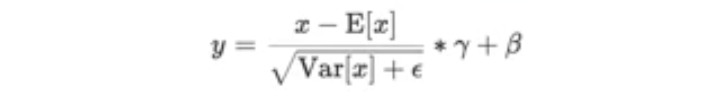

#### `BATCH NORMALIZATION:`

* We don't want to just randomly initialize our parameters (weights & biases), because it can result into `Dead Neurons`. `(Some values of parameters get initialized such that, there is no effect of back propagation on that neurons, gradient remains zero all the time, already at the start.)`
* So, before doing batch normalization, we scaled our weights and biases so our inputs and outputs remain roughly gaussian of same mean and standard deviation, such as by using `kaiming init`, and so they don't become dead neurons.
* But in practice, we will not have only one hidden layer, that is, we will have multiple hidden layers, and `then scaling all the weights and biases like this will not be efficient and easily possible`, so `this method of initialization is depricated.`

=> That's where the idea comes of `batch normalization`.

* It says that, rather than making all the weights & biases normalized, let's `simply normalize our hidden layer's values`, before giving these values into `activation functions`, because than, not all the hidden layer neuron's gradient will become `zero` on back prop, and `our model will remain optimum`.
  * before giving values to activation function, Our hidden layer values are:
    * `hpreact = embcat @ W1 + b1`
    * So batch normalize (providing gaussian distribution) it by this, `hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)`
    * Now, Note that, we want to `normalize them only during initialization`, that is we want our neural net's values to tune themselves accordingly to different examples, using back propagation, and we don't want them to standard normalized all the time,
    * we can do this by introducing `gain: bngain` and `shift: bnbias` which will provide some increase in values of gausian distribution (using gain) and shift accordingly (using bias), using back prop.
    * `hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias`, and now bngain and bnbias are also parameters, which will be calculated using backpropagation.

* Now stability of back propagation, comes with a terrible cost, that cost is , if you think deeply, you realize we are using all the examples in a batch to do batch normalization, but in practice, during prediction, we give one example as input to predict our output, then how our model will work, if we are giving only single example.
  * So, our h is a function of all the examples in a batch, so when we provide a input, h is going to change subtly and it's going to like jitter, if imagine sampling different examples because the statistics of mean and std are going to be impacted.
  * So, you get jitter for h and you'll get jitter for logits.
  * Now, it looks like a `bug`, something undesirable, but in a very strange way this actually turns out to be `good` in neural network training and `as a side effect`, reason it to be good is that, 
  * You can think of this as a `regularizer`, you have your input and you get h, and then depending on the other examples, this h is generating a bit and so what that does is, it's effectively padding out any one of these input examples and it's introducing little bit of `entropy`. and because of it padding out, it's actually kind of like a form of data augmentation, makes it harder for the neural nets to overfit to these concrete specific examples, so by introducing all these noise it actually pads out the examples and it regularizes the neural net and that's one of the reasons why this is deceivingly as a second order effect, This batch normalization also acts like a `regularizer`.


* But it gives a lot of bugs, so people liked to move different normalizations, such as layer normalization, instance normalization, group normalization and so on. 

`NOTE:` Clearly, you can see in `hpreact` due to subtraction, bias `b1` is useless, so don't use them.

* `FOR A NOTE`,  Something same is happening in the `resnet50` in `CNN`, `convolution => batch normalization => relu activation`.

* `In Pytorch we use above batch normalization as:`
  * `torch.nn.BatchNorm1d(num_features, eps=1e-05), momentum=0.1, affline=True, track_running_stats=True, device=None, dtype=None)`
    * `num_features:` here it is 200.
    * `eps:` value of epsilon `ε`
    * `momentum:` `0.001` used in bnmean_running and bnstd_running, during training.
    * `affline:` whether this batch normalization has `bngain` and `bnbias` or not. 
    * `track_running_stats:` determining whether or not bachelorization layer of pytorch will be doing this `bnmean_running and bnstd_running`.
    * `device:` On which device we are going to run, CPU or GPU or TPU.
    * `dtype:` what data type should it have, Half-precision, single-precision, double-precision and so on.

* Just Remember, We removed `hockey stick graph` initially from loss curve, by giving `proper initialization`, because we don't want our model to waste its iterations on this wasteful loss decrease, and so want our model to provide better result, `more less loss` .

* Also, no one likes this `batch normalization layer` during training, it causes lot amount of bugs because it's coupling examples  in the foward pass of a neural net.

* So try to avoid it as much as possible, some of the other alternatives of these layers are `group normalization`, `layer normalization`, etc.